In [1]:
from torch.utils.data import WeightedRandomSampler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
import time
import os
import copy
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
from torchvision.datasets import ImageFolder
import numpy as np
import matplotlib.pyplot as plt
import cv2
import numpy as np
import imageio as io
from PIL import Image
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

import torchmetrics
import pytorch_lightning as pl

import data_loader as dl
import experiments as e


!python --version
!nvcc --version
!pip install nvcc4jupyter
%load_ext nvcc4jupyter
class_names = ['Abstract_Expressionism','Baroque','Cubism', 'Fauvism', 'Impressionism','Minimalism','Naive_Art_Primitivism','Pointillism','Rococo','Ukiyo_e']
device = 'cuda'

num_classes = 10


Python 3.10.12
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Mon_Apr__3_17:16:06_PDT_2023
Cuda compilation tools, release 12.1, V12.1.105
Build cuda_12.1.r12.1/compiler.32688072_0
Source files will be saved in "/tmp/tmpu4ep5wf0".


In [2]:
import os
os.cpu_count()


128

In [4]:
!pip install scikit-learn
!pip install matplotlib
! pip install imageio
! pip install cv2
! pip install scikit-image
!pip install opencv-python-headless

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 52.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 KB 78.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 28.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.0/325.0 KB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 9.3 MB/s eta 0:00:00ta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.1/111.1 KB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 1.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.8/315.8 KB 2.5 MB/s eta 0:00:00a 0:00:01
ERROR: Could not find a version that satisfies the requirement cv2 (from versions: none)
ERROR: No matching distribution found for cv2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 5.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.8/226.8 KB 16.2 MB/s eta 0:00:00
     

In [3]:
!pip install torchsampler
!pip install xgboost
!pip install torchmetrics
!pip install pytorch_lightning
!pip install optuna
!pip install memory_profiler

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 18.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 766.7/766.7 MB 4.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 56.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 12.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 14.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 69.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 KB 44.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 16.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 37.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 30.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 25.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━

<h1> parameter search </h1>

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pickle
import numpy as np
with open('X_mobilenet_v3_b15.pickle', 'rb') as handle:
    train_data = pickle.load(handle)
with open('Y_mobilenet_v3_b15.pickle', 'rb') as handle:
    train_labels = pickle.load(handle)

X_train, X_test, y_train, y_test = train_test_split(train_data, train_labels, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
train_data_scaled = scaler.fit_transform(train_data)

train_labels = np.array(train_labels)
train_labels = train_labels.ravel()


print(f"Train: {np.shape(X_train)}, Test: {np.shape(X_test)}")
print(f"Train: {np.shape(train_data)}, Test: {np.shape(train_labels)}")

Train: (14804, 259), Test: (3701, 259)
Train: (18505, 259), Test: (18505,)


In [5]:
! pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 26.5 MB/s eta 0:00:00


[I 2025-03-29 19:12:44,985] A new study created in RDB with name: xg_mb_15
[I 2025-03-29 19:14:28,011] Trial 2 finished with value: 0.7125965787313583 and parameters: {'n_estimators': 1100, 'max_depth': 49, 'learning_rate': 0.28299006701066154, 'subsample': 0.6160977933973913, 'colsample_bytree': 0.7877966048772999, 'gamma': 2.2862981707629277, 'reg_lambda': 0.0827894122210533, 'reg_alpha': 6.579190585702464}. Best is trial 2 with value: 0.7125965787313583.
[I 2025-03-29 19:14:28,063] Trial 7 finished with value: 0.7364184283969314 and parameters: {'n_estimators': 200, 'max_depth': 42, 'learning_rate': 0.10015473038784929, 'subsample': 0.620290904841466, 'colsample_bytree': 0.6450228873800145, 'gamma': 3.6277479673021737, 'reg_lambda': 2.1432964529763443, 'reg_alpha': 0.08524407592073138}. Best is trial 7 with value: 0.7364184283969314.
[I 2025-03-29 19:16:38,297] Trial 0 finished with value: 0.7970526248213889 and parameters: {'n_estimators': 1000, 'max_depth': 19, 'learning_rate': 0.

Best parameters for classifier: {'n_estimators': 700, 'max_depth': 22, 'learning_rate': 0.010895082560719832, 'subsample': 0.9138556850042981, 'colsample_bytree': 0.867711234112047, 'gamma': 0.6811915438010995, 'reg_lambda': 0.15083629452333544, 'reg_alpha': 0.384178464344064}
Best F1-score for classifier: 0.8072158822651072


/tmp/ipykernel_1177/2022105271.py:52: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study)


<Figure size 800x600 with 0 Axes>

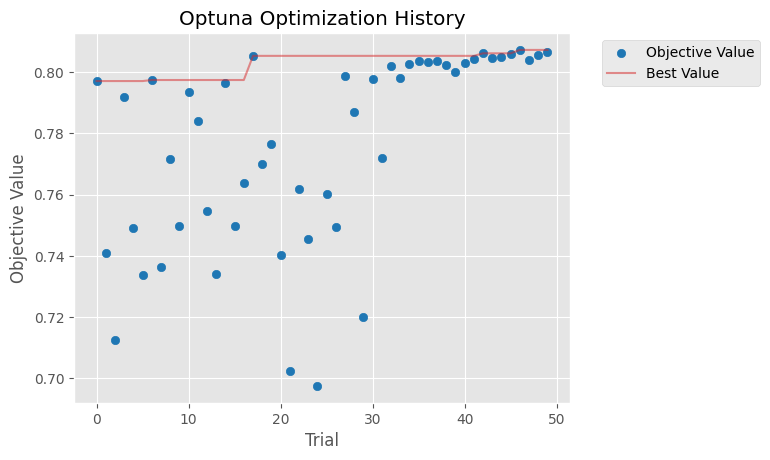

/tmp/ipykernel_1177/2022105271.py:58: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study)


<Figure size 800x600 with 0 Axes>

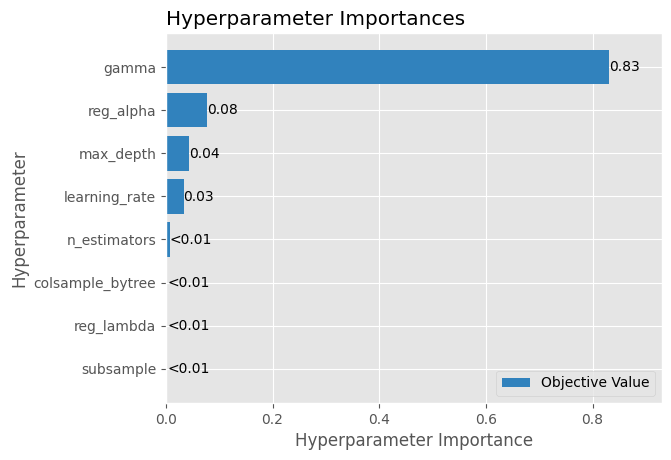

In [7]:
import optuna
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer, f1_score
from joblib import parallel_backend
import numpy as np
import logging
import xgboost as xgb


def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 200, 1200, step=100),  
        "max_depth": trial.suggest_int("max_depth", 3, 50),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 0.9),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-2, 10, log=True),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-2, 10, log=True),
        "objective": "multi:softmax",  
        "eval_metric": "mlogloss",
        "tree_method": "hist",  
    }

    model = xgb.XGBClassifier(**params, random_state=42, n_jobs=-1)

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    
    scorer = make_scorer(f1_score, average="weighted")
    scores = cross_val_score(model, train_data_scaled, train_labels, scoring=scorer, cv=skf, n_jobs=4)
    score = np.mean(scores)
    logging.info(f"Trial {trial.number} finished with value: {score:.5f} and parameters: {trial.params}")

    return score


study = optuna.create_study(direction="maximize", pruner=optuna.pruners.MedianPruner(), study_name= "xg_mb_15",storage="sqlite:///xg_mb_15.db")
study.optimize(objective, n_trials=50, n_jobs=16)

df = study.trials_dataframe()
df.to_csv("or_xg_mb_15.csv", index=False)
logging.info("Optuna study completed. Results saved to optuna_results.csv.")

best_params = study.best_params
logging.info(f"Best parameters: {best_params}")
print("Best parameters for classifier:", study.best_params)
print("Best F1-score for classifier:", study.best_value)

plt.figure(figsize=(8, 6))
optuna.visualization.matplotlib.plot_optimization_history(study)
plt.title("Optuna Optimization History")
plt.savefig("op_xg_mb_15.png")
plt.show()

plt.figure(figsize=(8, 6))
optuna.visualization.matplotlib.plot_param_importances(study)
plt.savefig("pi_xg_mb_15.png")
plt.show()

logging.info("Plots saved: optimization_history.png and param_importance.png")


[I 2025-03-29 21:11:36,765] A new study created in RDB with name: mlp_mb_15
INFO:optuna.storages._rdb.storage:A new study created in RDB with name: mlp_mb_15
/tmp/ipykernel_1177/2509293204.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate_init = trial.suggest_loguniform('learning_rate_init', 1e-5, 1e-2)
/tmp/ipykernel_1177/2509293204.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform('alpha', 1e-6, 1e-2)
/tmp/ipykernel_1177/2509293204.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float

Best parameters for RF: {'hidden_layer_1': 450, 'hidden_layer_2': 168, 'hidden_layer_3': 128, 'solver': 'adam', 'learning_rate_init': 0.0021200237363646563, 'alpha': 1.0454992501357614e-05, 'batch_size': 64, 'activation': 'logistic', 'max_iter': 637}
Best F1-score for RF: 0.7383152410363849


/tmp/ipykernel_1177/2509293204.py:57: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study)


<Figure size 800x600 with 0 Axes>

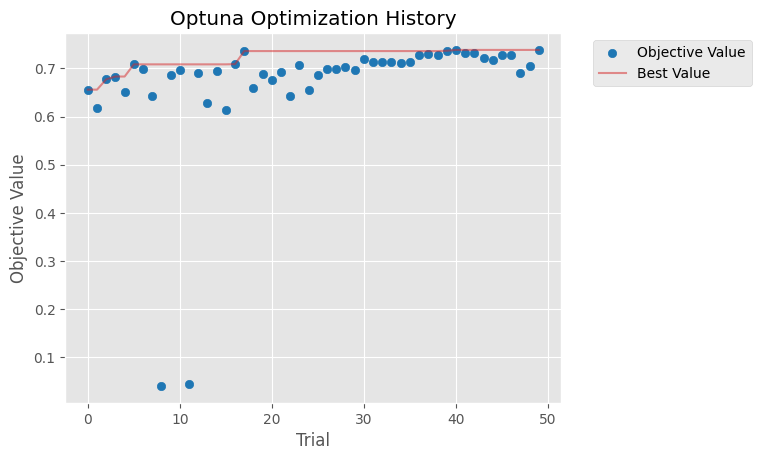

/tmp/ipykernel_1177/2509293204.py:63: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study)


<Figure size 800x600 with 0 Axes>

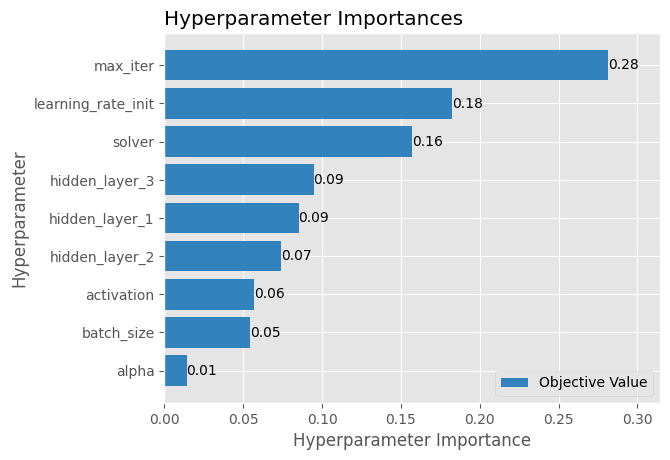

In [8]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer, f1_score
from sklearn.datasets import make_classification
import optuna

optuna.logging.enable_propagation()
optuna.logging.set_verbosity(optuna.logging.INFO)

def objective(trial):
    hidden_layer_1 = trial.suggest_int('hidden_layer_1', 128, 512)
    hidden_layer_2 = trial.suggest_int('hidden_layer_2', 64, 256)
    hidden_layer_3 = trial.suggest_int('hidden_layer_3', 32, 128)
    solver = trial.suggest_categorical('solver', ['adam', 'sgd', 'lbfgs'])
    learning_rate_init = trial.suggest_loguniform('learning_rate_init', 1e-5, 1e-2)
    alpha = trial.suggest_loguniform('alpha', 1e-6, 1e-2) 
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128, 256])
    activation = trial.suggest_categorical('activation', ['relu', 'tanh', 'logistic'])
    max_iter = trial.suggest_int('max_iter', 200, 1000)

    model = MLPClassifier(
            hidden_layer_sizes=(hidden_layer_1, hidden_layer_2, hidden_layer_3),
            max_iter=max_iter,
            solver=solver,
            learning_rate="adaptive",
            learning_rate_init=learning_rate_init,
            early_stopping=True,
            alpha=alpha,
            batch_size=batch_size,
            activation=activation,
            random_state=42
        )

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    
    scorer = make_scorer(f1_score, average="weighted")
    scores = cross_val_score(model, train_data_scaled, train_labels, scoring=scorer, cv=skf, n_jobs=4)
    score = np.mean(scores)
    logging.info(f"Trial {trial.number} finished with value: {score:.5f} and parameters: {trial.params}")

    return score


study = optuna.create_study( study_name= "mlp_mb_15",storage="sqlite:///mlp_mb_15.db",direction="maximize", pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=50, n_jobs=16)

df = study.trials_dataframe()
df.to_csv("ormlp_mb_15.csv", index=False)
logging.info("Optuna study completed. Results saved to optuna_results.csv.")

best_params = study.best_params
logging.info(f"Best parameters: {best_params}")
print("Best parameters for RF:", study.best_params)
print("Best F1-score for RF:", study.best_value)

plt.figure(figsize=(8, 6))
optuna.visualization.matplotlib.plot_optimization_history(study)
plt.title("Optuna Optimization History")
plt.savefig("oh_mlp_mb_15.png")
plt.show()

plt.figure(figsize=(8, 6))
optuna.visualization.matplotlib.plot_param_importances(study)
#plt.title("Hyperparameter Importance")
plt.savefig("pi_mlp_mb_15.png")
plt.show()

logging.info("Plots saved: optimization_history.png and param_importance.png")


In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer, f1_score
from sklearn.datasets import make_classification
from sklearn.svm import SVC

optuna.logging.enable_propagation()
optuna.logging.set_verbosity(optuna.logging.INFO)

def objective(trial):
    kernel = trial.suggest_categorical("kernel", ["linear", "rbf", "poly"])
    C = trial.suggest_float("C", 0.01, 100)

    if kernel == "rbf" or kernel == "poly":
        gamma = trial.suggest_float("gamma", 0.0001, 10)
    else:
        gamma = "scale"  
    
    if kernel == "poly":
        degree = trial.suggest_int("degree", 2, 5)
    else:
        degree = 3  

    model = SVC(C=C, kernel=kernel, gamma=gamma, degree=degree, random_state=42)

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    
    scorer = make_scorer(f1_score, average="weighted")
    scores = cross_val_score(model, train_data_scaled, train_labels, scoring=scorer, cv=skf, n_jobs=4)
    score = np.mean(scores)
    logging.info(f"Trial {trial.number} finished with value: {score:.5f} and parameters: {trial.params}")

    return score


study = optuna.create_study( study_name= "svc_mb_15",storage="sqlite:///svc_mb_15.db",direction="maximize", pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=50)

df = study.trials_dataframe()
df.to_csv("orsvc_mb_15.csv", index=False)
logging.info("Optuna study completed. Results saved to optuna_results.csv.")

best_params = study.best_params
logging.info(f"Best parameters: {best_params}")
print("Best parameters for RF:", study.best_params)
print("Best F1-score for RF:", study.best_value)

plt.figure(figsize=(8, 6))
optuna.visualization.matplotlib.plot_optimization_history(study)
plt.title("Optuna Optimization History")
plt.savefig("ohsvc_mb_15.png")
plt.show()

plt.figure(figsize=(8, 6))
optuna.visualization.matplotlib.plot_param_importances(study)
#plt.title("Hyperparameter Importance")
plt.savefig("pisvc_mb_15.png")
plt.show()

logging.info("Plots saved: optimization_history.png and param_importance.png")


[I 2025-03-29 22:08:34,005] A new study created in RDB with name: svc_mb_15
INFO:optuna.storages._rdb.storage:A new study created in RDB with name: svc_mb_15
[I 2025-03-29 22:09:36,359] Trial 0 finished with value: 0.7579053763334103 and parameters: {'kernel': 'poly', 'C': 92.52209593902028, 'gamma': 7.104353526129041, 'degree': 3}. Best is trial 0 with value: 0.7579053763334103.
INFO:optuna.study.study:Trial 0 finished with value: 0.7579053763334103 and parameters: {'kernel': 'poly', 'C': 92.52209593902028, 'gamma': 7.104353526129041, 'degree': 3}. Best is trial 0 with value: 0.7579053763334103.
[I 2025-03-29 22:11:12,287] Trial 1 finished with value: 0.04092019303198129 and parameters: {'kernel': 'rbf', 'C': 50.55784877052566, 'gamma': 9.413760351031744}. Best is trial 0 with value: 0.7579053763334103.
INFO:optuna.study.study:Trial 1 finished with value: 0.04092019303198129 and parameters: {'kernel': 'rbf', 'C': 50.55784877052566, 'gamma': 9.413760351031744}. Best is trial 0 with val

In [7]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer, f1_score
from sklearn.datasets import make_classification
from sklearn.svm import SVC
import logging
import optuna
optuna.logging.enable_propagation()
optuna.logging.set_verbosity(optuna.logging.INFO)

def objective(trial):
    kernel = trial.suggest_categorical("kernel", ["linear", "rbf", "poly"])
    C = trial.suggest_float("C", 0.01, 100)

    if kernel == "rbf" or kernel == "poly":
        gamma = trial.suggest_float("gamma", 0.0001, 10)
    else:
        gamma = "scale"  
    
    if kernel == "poly":
        degree = trial.suggest_int("degree", 2, 5)
    else:
        degree = 3  

    model = SVC(C=C, kernel=kernel, gamma=gamma, degree=degree, random_state=42)

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    
    scorer = make_scorer(f1_score, average="weighted")
    scores = cross_val_score(model, train_data_scaled, train_labels, scoring=scorer, cv=skf, n_jobs=4)
    score = np.mean(scores)
    logging.info(f"Trial {trial.number} finished with value: {score:.5f} and parameters: {trial.params}")

    return score


study = optuna.load_study( study_name= "svc_mb_15",storage="sqlite:///svc_mb_15.db")
study.optimize(objective, n_trials=50)

df = study.trials_dataframe()
df.to_csv("orsvc_mb_15.csv", index=False)
logging.info("Optuna study completed. Results saved to optuna_results.csv.")

best_params = study.best_params
logging.info(f"Best parameters: {best_params}")
print("Best parameters for RF:", study.best_params)
print("Best F1-score for RF:", study.best_value)

plt.figure(figsize=(8, 6))
optuna.visualization.matplotlib.plot_optimization_history(study)
plt.title("Optuna Optimization History")
plt.savefig("ohsvc_mb_15.png")
plt.show()

plt.figure(figsize=(8, 6))
optuna.visualization.matplotlib.plot_param_importances(study)
#plt.title("Hyperparameter Importance")
plt.savefig("pisvc_mb_15.png")
plt.show()

logging.info("Plots saved: optimization_history.png and param_importance.png")


[I 2025-03-29 22:43:55,607] Trial 4 finished with value: 0.7310269382468695 and parameters: {'kernel': 'poly', 'C': 66.67279051685824, 'gamma': 4.0559240012445485, 'degree': 2}. Best is trial 0 with value: 0.7579053763334103.
INFO:optuna.study.study:Trial 4 finished with value: 0.7310269382468695 and parameters: {'kernel': 'poly', 'C': 66.67279051685824, 'gamma': 4.0559240012445485, 'degree': 2}. Best is trial 0 with value: 0.7579053763334103.
[I 2025-03-29 22:45:01,111] Trial 5 finished with value: 0.7033463901040853 and parameters: {'kernel': 'poly', 'C': 92.9335276015327, 'gamma': 7.935855217691638, 'degree': 5}. Best is trial 0 with value: 0.7579053763334103.
INFO:optuna.study.study:Trial 5 finished with value: 0.7033463901040853 and parameters: {'kernel': 'poly', 'C': 92.9335276015327, 'gamma': 7.935855217691638, 'degree': 5}. Best is trial 0 with value: 0.7579053763334103.
[I 2025-03-29 22:46:56,166] Trial 6 finished with value: 0.04102970687379523 and parameters: {'kernel': 'rbf

KeyboardInterrupt: 

Resnet 3 svc

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pickle
import numpy as np
with open('X_resnet_3.pickle', 'rb') as handle:
    train_data = pickle.load(handle)
with open('Y_resnet_3.pickle', 'rb') as handle:
    train_labels = pickle.load(handle)

X_train, X_test, y_train, y_test = train_test_split(train_data, train_labels, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
train_data_scaled = scaler.fit_transform(train_data)

train_labels = np.array(train_labels)
train_labels = train_labels.ravel()


print(f"Train: {np.shape(X_train)}, Test: {np.shape(X_test)}")
print(f"Train: {np.shape(train_data)}, Test: {np.shape(train_labels)}")

Train: (14804, 355), Test: (3701, 355)
Train: (18505, 355), Test: (18505,)


In [ ]:
"""from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer, f1_score
from sklearn.datasets import make_classification
from sklearn.svm import SVC

optuna.logging.enable_propagation()
optuna.logging.set_verbosity(optuna.logging.INFO)

def objective(trial):
    kernel = trial.suggest_categorical("kernel", ["linear", "rbf", "poly"])
    C = trial.suggest_float("C", 0.01, 100)

    if kernel == "rbf" or kernel == "poly":
        gamma = trial.suggest_float("gamma", 0.0001, 10)
    else:
        gamma = "scale"  
    
    if kernel == "poly":
        degree = trial.suggest_int("degree", 2, 5)
    else:
        degree = 3  

    model = SVC(C=C, kernel=kernel, gamma=gamma, degree=degree, random_state=42)

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    
    scorer = make_scorer(f1_score, average="weighted")
    scores = cross_val_score(model, train_data_scaled, train_labels, scoring=scorer, cv=skf, n_jobs=4)
    score = np.mean(scores)
    logging.info(f"Trial {trial.number} finished with value: {score:.5f} and parameters: {trial.params}")

    return score


study = optuna.create_study( study_name= "svc_rs_3",storage="sqlite:///svc_rs_3.db",direction="maximize", pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=50)

df = study.trials_dataframe()
df.to_csv("orsvc_rs_3.csv", index=False)
logging.info("Optuna study completed. Results saved to optuna_results.csv.")

best_params = study.best_params
logging.info(f"Best parameters: {best_params}")
print("Best parameters for RF:", study.best_params)
print("Best F1-score for RF:", study.best_value)

plt.figure(figsize=(8, 6))
optuna.visualization.matplotlib.plot_optimization_history(study)
plt.title("Optuna Optimization History")
plt.savefig("ohsvc_rs_3.png")
plt.show()

plt.figure(figsize=(8, 6))
optuna.visualization.matplotlib.plot_param_importances(study)
#plt.title("Hyperparameter Importance")
plt.savefig("pisvc_rs_3.png")
plt.show()

logging.info("Plots saved: optimization_history.png and param_importance.png")
"""

[I 2025-03-30 06:27:52,436] A new study created in RDB with name: mlp_rs_3
INFO:optuna.storages._rdb.storage:A new study created in RDB with name: mlp_rs_3
/tmp/ipykernel_2979/2305775449.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate_init = trial.suggest_loguniform('learning_rate_init', 1e-5, 1e-2)
/tmp/ipykernel_2979/2305775449.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform('alpha', 1e-6, 1e-2)
/tmp/ipykernel_2979/2305775449.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(.

Best parameters for RF: {'hidden_layer_1': 440, 'hidden_layer_2': 170, 'hidden_layer_3': 69, 'solver': 'adam', 'learning_rate_init': 0.0005148340246615198, 'alpha': 1.6324225737227937e-05, 'batch_size': 64, 'activation': 'logistic', 'max_iter': 610}
Best F1-score for RF: 0.8166818621320692


/tmp/ipykernel_2979/2305775449.py:57: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study)


<Figure size 800x600 with 0 Axes>

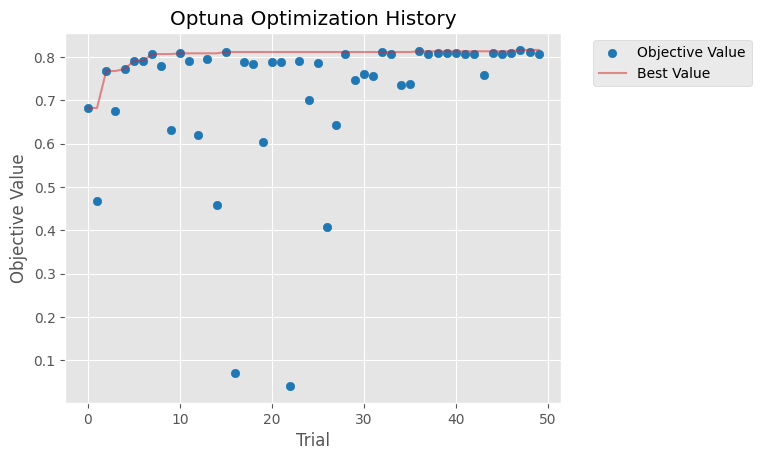

/tmp/ipykernel_2979/2305775449.py:63: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study)


<Figure size 800x600 with 0 Axes>

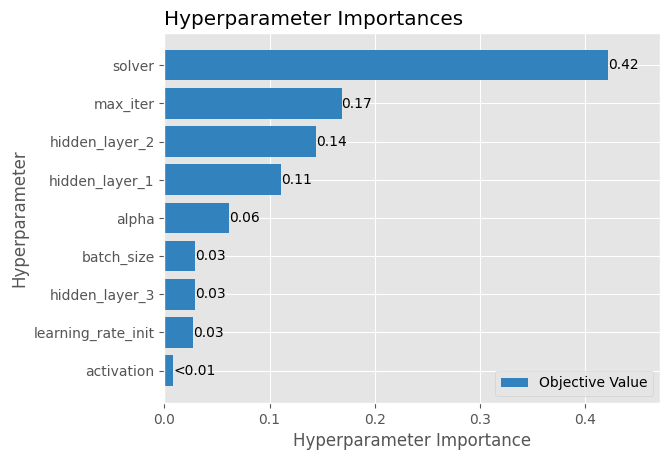

In [9]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer, f1_score
from sklearn.datasets import make_classification
import optuna

optuna.logging.enable_propagation()
optuna.logging.set_verbosity(optuna.logging.INFO)

def objective(trial):
    hidden_layer_1 = trial.suggest_int('hidden_layer_1', 128, 512)
    hidden_layer_2 = trial.suggest_int('hidden_layer_2', 64, 256)
    hidden_layer_3 = trial.suggest_int('hidden_layer_3', 32, 128)
    solver = trial.suggest_categorical('solver', ['adam', 'sgd', 'lbfgs'])
    learning_rate_init = trial.suggest_loguniform('learning_rate_init', 1e-5, 1e-2)
    alpha = trial.suggest_loguniform('alpha', 1e-6, 1e-2) 
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128, 256])
    activation = trial.suggest_categorical('activation', ['relu', 'tanh', 'logistic'])
    max_iter = trial.suggest_int('max_iter', 200, 1000)

    model = MLPClassifier(
            hidden_layer_sizes=(hidden_layer_1, hidden_layer_2, hidden_layer_3),
            max_iter=max_iter,
            solver=solver,
            learning_rate="adaptive",
            learning_rate_init=learning_rate_init,
            early_stopping=True,
            alpha=alpha,
            batch_size=batch_size,
            activation=activation,
            random_state=42
        )

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    
    scorer = make_scorer(f1_score, average="weighted")
    scores = cross_val_score(model, train_data_scaled, train_labels, scoring=scorer, cv=skf, n_jobs=4)
    score = np.mean(scores)
    logging.info(f"Trial {trial.number} finished with value: {score:.5f} and parameters: {trial.params}")

    return score


study = optuna.create_study( study_name= "mlp_rs_3",storage="sqlite:///mlp_rs_3.db",direction="maximize", pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=50, n_jobs=16)

df = study.trials_dataframe()
df.to_csv("ormlp_rs_3.csv", index=False)
logging.info("Optuna study completed. Results saved to optuna_results.csv.")

best_params = study.best_params
logging.info(f"Best parameters: {best_params}")
print("Best parameters for RF:", study.best_params)
print("Best F1-score for RF:", study.best_value)

plt.figure(figsize=(8, 6))
optuna.visualization.matplotlib.plot_optimization_history(study)
plt.title("Optuna Optimization History")
plt.savefig("oh_mlp_rs_3.png")
plt.show()

plt.figure(figsize=(8, 6))
optuna.visualization.matplotlib.plot_param_importances(study)
#plt.title("Hyperparameter Importance")
plt.savefig("pi_mlp_rs_3.png")
plt.show()

logging.info("Plots saved: optimization_history.png and param_importance.png")


In [ ]:
!pip install mathplotlib

ERROR: Could not find a version that satisfies the requirement mathplotlib (from versions: none)
ERROR: No matching distribution found for mathplotlib


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pickle
import numpy as np
with open('X_densenet_tr1.pickle', 'rb') as handle:
    train_data = pickle.load(handle)
with open('Y_densenet_tr1.pickle', 'rb') as handle:
    train_labels = pickle.load(handle)

X_train, X_test, y_train, y_test = train_test_split(train_data, train_labels, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
train_data_scaled = scaler.fit_transform(train_data)

train_labels = np.array(train_labels)
train_labels = train_labels.ravel()


print(f"Train: {np.shape(X_train)}, Test: {np.shape(X_test)}")
print(f"Train: {np.shape(train_data)}, Test: {np.shape(train_labels)}")

Train: (14804, 227), Test: (3701, 227)
Train: (18505, 227), Test: (18505,)


[I 2025-03-30 08:00:25,557] A new study created in RDB with name: xg_dn1
INFO:optuna.storages._rdb.storage:A new study created in RDB with name: xg_dn1
/venv/main/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[I 2025-03-30 08:03:01,597] Trial 0 finished with value: 0.788476603478255 and parameters: {'n_estimators': 800, 'max_depth': 18, 'learning_rate': 0.0471918707004088, 'subsample': 0.7046895915356173, 'colsample_bytree': 0.635194566470658, 'gamma': 3.409294124423827, 'reg_lambda': 0.24833217905925647, 'reg_alpha': 1.439564458488506}. Best is trial 0 with value: 0.788476603478255.
INFO:optuna.study.study:Trial 0 finished with value: 0.788476603478255 and parameters: {'n_estimators': 800, 'max_depth': 18, 'learning_rate': 0.0471918707004088, 'subsample': 0.7046895915356173, 'colsample_bytree': 0.

Best parameters for classifier: {'n_estimators': 300, 'max_depth': 49, 'learning_rate': 0.07201562389911595, 'subsample': 0.8220334044148243, 'colsample_bytree': 0.6772086334316961, 'gamma': 0.025713845099456734, 'reg_lambda': 2.7824249258207767, 'reg_alpha': 0.35028369504157825}
Best F1-score for classifier: 0.8438066605949694


/tmp/ipykernel_2979/3180528570.py:52: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study)


<Figure size 800x600 with 0 Axes>

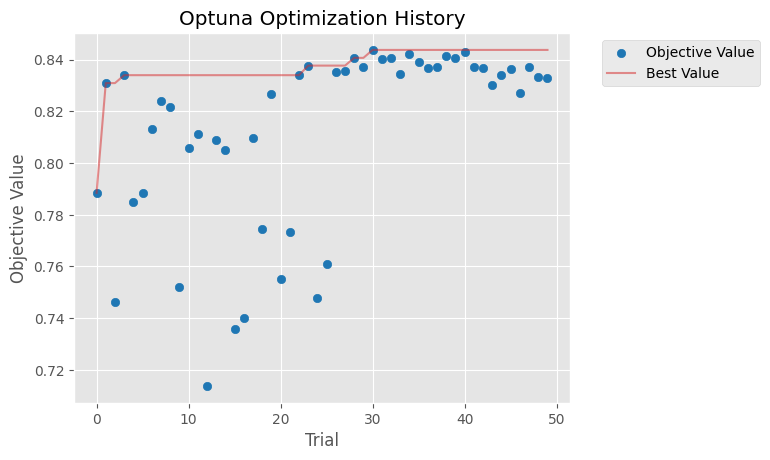

/tmp/ipykernel_2979/3180528570.py:58: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study)


<Figure size 800x600 with 0 Axes>

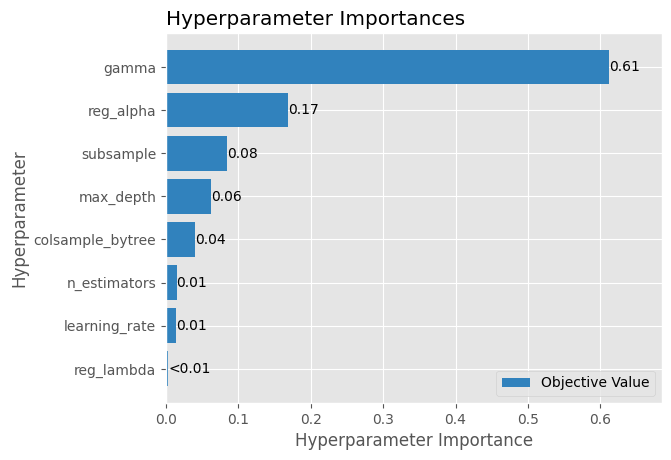

In [11]:
import optuna
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer, f1_score
from joblib import parallel_backend
import numpy as np
import logging
import xgboost as xgb


def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 200, 1200, step=100),  
        "max_depth": trial.suggest_int("max_depth", 3, 50),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 0.9),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-2, 10, log=True),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-2, 10, log=True),
        "objective": "multi:softmax",  
        "eval_metric": "mlogloss",
        "tree_method": "hist",  
    }

    model = xgb.XGBClassifier(**params, random_state=42, n_jobs=-1)

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    
    scorer = make_scorer(f1_score, average="weighted")
    scores = cross_val_score(model, train_data_scaled, train_labels, scoring=scorer, cv=skf, n_jobs=4)
    score = np.mean(scores)
    logging.info(f"Trial {trial.number} finished with value: {score:.5f} and parameters: {trial.params}")

    return score


study = optuna.create_study(direction="maximize", pruner=optuna.pruners.MedianPruner(), study_name= "xg_dn1",storage="sqlite:///xg_dn1.db")
study.optimize(objective, n_trials=50, n_jobs=16)

df = study.trials_dataframe()
df.to_csv("or_xg_dn1.csv", index=False)
logging.info("Optuna study completed. Results saved to optuna_results.csv.")

best_params = study.best_params
logging.info(f"Best parameters: {best_params}")
print("Best parameters for classifier:", study.best_params)
print("Best F1-score for classifier:", study.best_value)

plt.figure(figsize=(8, 6))
optuna.visualization.matplotlib.plot_optimization_history(study)
plt.title("Optuna Optimization History")
plt.savefig("op_xg_dn1.png")
plt.show()

plt.figure(figsize=(8, 6))
optuna.visualization.matplotlib.plot_param_importances(study)
plt.savefig("pi_xg_dn1.png")
plt.show()

logging.info("Plots saved: optimization_history.png and param_importance.png")


In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pickle
import optuna 
import logging

with open('X_densenet_tr2.pickle', 'rb') as handle:
    train_data = pickle.load(handle)
with open('Y_densenet_tr2.pickle', 'rb') as handle:
    train_labels = pickle.load(handle)

X_train, X_test, y_train, y_test = train_test_split(train_data, train_labels, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
train_data_scaled = scaler.transform(train_data)

train_labels = np.array(train_labels)
train_labels = train_labels.ravel()


print(f"Train: {len(X_train)}, Test: {len(X_test)}")

Train: 14804, Test: 3701


In [ ]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer, f1_score
from joblib import parallel_backend
import numpy as np
import logging


def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 200, 1200, step=100),  # More trees for better performance
        "max_depth": trial.suggest_int("max_depth", 3, 50),  # Shallow trees avoid overfitting, deeper trees capture complexity
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),  # Regularization to prevent overfitting
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),  # Smaller leaf size = more flexible tree
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", None]),  # Feature selection
        "bootstrap": trial.suggest_categorical("bootstrap", [True, False]),  # Whether to use bootstrapping
        "criterion": trial.suggest_categorical("criterion", ["gini", "entropy"]),  # Splitting criteria
    }

    model = RandomForestClassifier(**params, random_state=42, n_jobs=-1)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    
    scorer = make_scorer(f1_score, average="weighted")
    scores = cross_val_score(model, train_data_scaled, train_labels, scoring=scorer, cv=skf, n_jobs=5)
    score = np.mean(scores)
    logging.info(f"Trial {trial.number} finished with value: {score:.5f} and parameters: {trial.params}")

    return score


study1 = optuna.create_study( study_name= "rf_dn_2",storage="sqlite:///rf_dn_2.db",direction="maximize", pruner=optuna.pruners.MedianPruner())
study1.optimize(objective, n_trials=50,n_jobs=5)

df = study1.trials_dataframe()
df.to_csv("rf_dn_2.csv", index=False)
logging.info("Optuna study completed. Results saved to optuna_results.csv.")

best_params = study1.best_params
logging.info(f"Best parameters: {best_params}")
print("Best parameters for classifier:", study1.best_params)
print("Best F1-score for classifier:", study1.best_value)

plt.figure(figsize=(8, 6))
optuna.visualization.matplotlib.plot_optimization_history(study1)
plt.title("Optuna Optimization History")
plt.savefig("op_rf_dn_2_5.png")
plt.show()

plt.figure(figsize=(8, 6))
optuna.visualization.matplotlib.plot_param_importances(study1)
#plt.title("Hyperparameter Importance")
plt.savefig("pi_rf_dn_2.png")
plt.show()

logging.info("Plots saved: optimization_history.png and param_importance.png")


[I 2025-03-30 09:57:18,976] A new study created in RDB with name: rf_dn_2
INFO:optuna.storages._rdb.storage:A new study created in RDB with name: rf_dn_2
[I 2025-03-30 09:57:43,705] Trial 0 finished with value: 0.8302218803209784 and parameters: {'n_estimators': 1000, 'max_depth': 31, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'bootstrap': False, 'criterion': 'gini'}. Best is trial 0 with value: 0.8302218803209784.
INFO:optuna.study.study:Trial 0 finished with value: 0.8302218803209784 and parameters: {'n_estimators': 1000, 'max_depth': 31, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'bootstrap': False, 'criterion': 'gini'}. Best is trial 0 with value: 0.8302218803209784.
[I 2025-03-30 09:57:49,800] Trial 2 finished with value: 0.791483197004953 and parameters: {'n_estimators': 900, 'max_depth': 44, 'min_samples_split': 20, 'min_samples_leaf': 4, 'max_features': 'log2', 'bootstrap': True, 'criterion': 'gini'}. Best is trial 0 with 